### Importing Libraries

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf

# from scipy.stats import ttest_1samp
# from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
# # pd.options.display.float_format = '{:.6f}'.format

### Importing Data

In [2]:
data = pd.read_csv("sgemm_product.csv")
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


Adding a field 'Runtime' - which is our final dependent variable for linear regression

In [3]:
data['Runtime'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].sum(axis = 1)/4

In [4]:
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625


### EDA

In [5]:
# Check for NAs
print('NA values count: \n{}'.format(data.isnull().sum().sum()))

NA values count: 
0


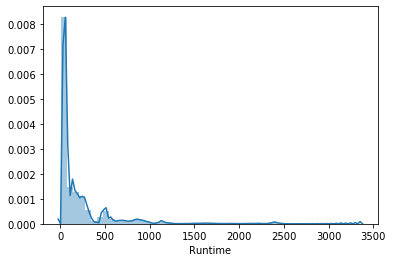

In [6]:
#Distribution of dependent variable
sns.distplot(data['Runtime'])

The distribution is heavily skewed towards the right. We will try to bring the skew back to that of a normal distribution by taking the log of the variable. We will further normalize the data by using MinMaxScaler from the sklearn library.

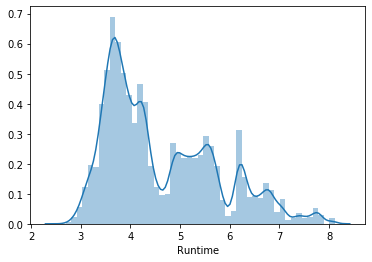

In [7]:
data['Runtime'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].sum(axis = 1)/4
data['Runtime'] = np.log(data['Runtime'])

#Distribution of dependent variable
sns.distplot(data['Runtime'])

Splitting into train, test

In [8]:
x_train ,x_test ,y_train , y_test = train_test_split(
    data.drop(columns = ['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)','Runtime']), 
    data[['Runtime']], test_size=0.3,  random_state=100)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

Normalizing data

In [9]:
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_train = sm.add_constant(x_train)
x_test = scaler.transform(x_test)
x_test = sm.add_constant(x_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

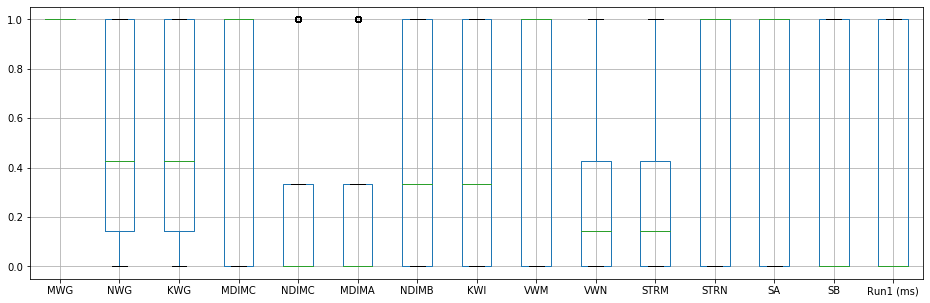

In [10]:
pd.DataFrame(x_train, columns = data.columns[:15]).boxplot(grid='True', figsize = [16,5])

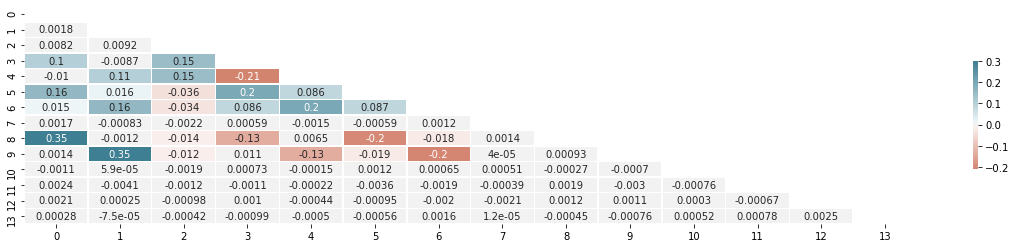

In [11]:
corr = pd.DataFrame(x_train[:,1:]).corr()
cmap = sns.diverging_palette(20, 220, n=200)#sns.diverging_palette(220, 10, as_cmap=True) #color set
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 4))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5} , annot = True);


### Defining functions for Linear Regression

#### #1. Calculate slope of the cost function

In [12]:
def calc_m_lin(m, alpha, x, y, length):
    return (m - alpha*(x.T @ (x @ m - y))/length)

#### #2. Calculate value of the cost function

In [13]:
def calc_cost_lin(m, x, y, length):
    return sum((x @ m - y)**2)/(2*length)

#### #3. Setting up the gradient descent algorithm

In [14]:
def grad_desc_lin(x, y, length, m, alpha, iters, costs, threshold = 0):
    
    for i in range(0,iters):
        cost = calc_cost_lin(m, x, y, length)[0]
        costs.append(cost)
        m = calc_m_lin(m, alpha, x, y, length)
        if i > 1 and (costs[len(costs) - 2] - costs[len(costs) - 1] <= threshold):
            break
    return [m, costs, i]

### #4. Function to print model outputs

In [15]:
def model_parameters(coeff, x, y, names):
    
    err = np.subtract(y, x@coeff)
    #Calculating R2 = 1 - sse/sst
    sse = np.sum(err**2)
    sst = np.sum((y - np.mean(y, axis = 0))**2) 
    r2 = 1 - (sse/sst)
    
    #Calculating Adj R2 = 1 - (1 - r2)*(n - 1)/(n - k - 1)
    adj_r2 = 1 - (1 - r2)*(len(x) - 1)/(len(x) - len(coeff) - 1)
    
    #variable name, coeff, p val, t - stat, std errors
    model_output = pd.DataFrame(columns = ['Variable', 'Coeff', 'Std Err', 'T- Val'])
    df = len(x) - len(coeff) - 1
    x_terms = np.sum(np.subtract(x, np.mean(x, axis = 0))**2, axis = 0)
    for i in range(0, len(coeff)):
        se = math.sqrt(sse/df)/math.sqrt(x_terms[i] + sys.float_info.epsilon)
        t  =coeff[i]/se
        model_output.loc[i] = [names[i], coeff[i][0], se, t[0]]
    print('Model Output:\n')
    print(model_output)
    print('\n')
    
    #Mean Absolute Error
    mae = np.sum(abs(err))/len(x)
    
    #Mean Squared Error
    mse = np.sum(err**2)/len(x)
    
    #Mean Absolute Percentage Error
    mape = 100 * np.sum(abs(1-err/y))/len(x)
    
    #Root Mean Squared Error
    rmse = math.sqrt(np.sum(err**2)/len(x))
    print("R2 of the estimated model: {}".format(r2))
    print("Adjusted R2 of the estimated model: {}".format(adj_r2))
    print('Mean Absolute Error: {}'.format(mae))
    print('Mean Squared Error: {}'.format(mse))
    print("Mean Absolute Percentage Error: {}%".format(mape))
    print("Root Mean Squared Error: {}".format(rmse))

### Fitting the model

Fitting the model for an initial alpha of 0.015, with 3500 iterations and not checking for any thresholds in the drop of costs

In [16]:
np.random.seed(0)
x_train = x_train
y_train = np.array(y_train).reshape(-1,1)
m = np.random.rand(x_train.shape[1],1)
alpha = 0.015
iters = 3500

In [17]:
betas = grad_desc_lin(x_train, y_train, len(x_train), m, alpha, iters, [])

Model Output:

   Variable     Coeff       Std Err        T- Val
0     const  0.182860  9.247641e+06  1.977375e-08
1       MWG  0.270184  8.840207e-04  3.056310e+02
2       NWG  0.198043  8.832961e-04  2.242088e+02
3       KWG  0.039167  6.824034e-04  5.739595e+01
4     MDIMC -0.226405  1.018653e-03 -2.222596e+02
5     NDIMC -0.212586  1.020894e-03 -2.082348e+02
6     MDIMA  0.006400  8.557265e-04  7.478601e+00
7     NDIMB  0.016397  8.563045e-04  1.914840e+01
8       KWI  0.000765  6.701688e-04  1.141174e+00
9       VWM  0.016927  1.201074e-03  1.409301e+01
10      VWN  0.029673  1.203464e-03  2.465621e+01
11     STRM -0.018537  6.701678e-04 -2.766047e+01
12     STRN  0.003370  6.701697e-04  5.029077e+00
13       SA -0.029451  6.701681e-04 -4.394549e+01
14       SB -0.002420  6.701679e-04 -3.610359e+00


R2 of the estimated model: 0.5501951481802103
Adjusted R2 of the estimated model: 0.550155249225855
Mean Absolute Error: 0.11100065264633283
Mean Squared Error: 0.018987205367502893
M

c:\users\abhis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


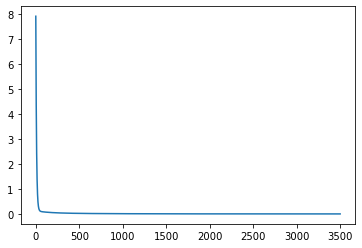

In [18]:
names = ['const'] + list(data.columns)
model_parameters(betas[0], x_train, y_train, names)
plt.plot(betas[1])
print('*'*60)
print('Final cost: {}\n'.format(betas[1][-1]))

Comparing with OLS regressor from the Statsmodels liibrary

In [19]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Sun, 09 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:51:12   Log-Likelihood:                 97108.
No. Observations:              169120   AIC:                        -1.942e+05
Df Residuals:                  169105   BIC:                        -1.940e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2298      0.001    186.212      0.0

As we can see, the coefficients from both the models are close to each other. The difference can be attributed to . We have not implemented L1 and L2 norm regularization for our models yet, and that is what we will do in the upcoming sections.

Comparing our models to the OLS regressor from the statsmodel library:

In [22]:
length = len(x_test)

y_hat_ols = model.predict(x_test)
err_ols = y_test.squeeze()-y_hat_ols

mae_ols = np.sum(np.absolute(err_ols))/length
mse_ols = np.sum(err_ols**2)/length
mape_ols = 100 * np.sum(np.absolute(1-err_ols/y_test.squeeze()))/length
rmse_ols = np.sqrt(np.sum(err_ols**2)/length)

y_hat_func = x_test@betas[0]
err_func = y_test-y_hat_func

mae_func = np.sum(np.absolute(err_func))/length
mse_func = np.sum(err_func**2)/length
mape_func = 100 * np.sum(np.absolute(1-err_func/y_test))/length
rmse_func = np.sqrt(np.sum(err_func**2)/length)

print('Mean Absolute Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n'.format(mae_ols, mae_func, -mae_ols+mae_func))
print('Mean Squared Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n'.format(mse_ols, mse_func, -mse_ols+mse_func))
print("Mean Absolute Percentage Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n".format(mape_ols, mape_func, -mape_ols+mape_func))
print("Root Mean Squared Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n".format(rmse_ols, rmse_func, -rmse_ols+rmse_func))

Mean Absolute Error: 
OLS: 0.10861; Function: 0.11047; Function - OLS: 0.00187

Mean Squared Error: 
OLS: 0.01839; Function: 0.01882; Function - OLS: 0.00042

Mean Absolute Percentage Error: 
OLS: 122.20342; Function: 122.35138; Function - OLS: 0.14796

Root Mean Squared Error: 
OLS: 0.13562; Function: 0.13717; Function - OLS: 0.00155



### Implementing L1 and L2 norms for Linear regression

To implement L1 and L2 norms, we just need to modify our cost function. We will add L1 and L2 weights to our cost function, leaving the other calculations intact.

In [23]:
def calc_m_lin(m, alpha, x, y, length):
    return (m - alpha*(x.T @ (x @ m - y))/length)

In [24]:
def calc_cost_lin_reg(m, x, y, length, reg, lambdaa):
    err = sum((x @ m - y)**2)/(2*length)
    if reg == 'l1' or reg == 'lasso':
        return err + lambdaa*np.sum(np.absolute(m[1:]))
    elif reg == 'l2' or reg == 'ridge':
        return err + lambdaa*np.sum(m[1:]**2)    
    elif reg == None:
        return err

In [25]:
def grad_desc_lin_reg(x, y, length, m, alpha, iters, costs, threshold = 0, reg = None, lambdaa = 0.01):
    
    for i in range(0,iters):
        cost = calc_cost_lin_reg(m, x, y, length, reg, lambdaa)[0]
        costs.append(cost)
        m = calc_m_lin(m, alpha, x, y, length)
        if i > 1 and (costs[len(costs) - 2] - costs[len(costs) - 1] <= threshold):
            break
    return [m, costs, i]

In [26]:
np.random.seed(0)
x_train = x_train
y_train = np.array(y_train).reshape(-1,1)
m = np.random.rand(x_train.shape[1],1)
alpha = 0.015
iters = 3500

In [27]:
betas_no_reg = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [])

Model Output:

   Variable     Coeff       Std Err        T- Val
0     const  0.182860  9.247641e+06  1.977375e-08
1       MWG  0.270184  8.840207e-04  3.056310e+02
2       NWG  0.198043  8.832961e-04  2.242088e+02
3       KWG  0.039167  6.824034e-04  5.739595e+01
4     MDIMC -0.226405  1.018653e-03 -2.222596e+02
5     NDIMC -0.212586  1.020894e-03 -2.082348e+02
6     MDIMA  0.006400  8.557265e-04  7.478601e+00
7     NDIMB  0.016397  8.563045e-04  1.914840e+01
8       KWI  0.000765  6.701688e-04  1.141174e+00
9       VWM  0.016927  1.201074e-03  1.409301e+01
10      VWN  0.029673  1.203464e-03  2.465621e+01
11     STRM -0.018537  6.701678e-04 -2.766047e+01
12     STRN  0.003370  6.701697e-04  5.029077e+00
13       SA -0.029451  6.701681e-04 -4.394549e+01
14       SB -0.002420  6.701679e-04 -3.610359e+00


R2 of the estimated model: 0.5501951481802103
Adjusted R2 of the estimated model: 0.550155249225855
Mean Absolute Error: 0.11100065264633283
Mean Squared Error: 0.018987205367502893
M

c:\users\abhis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


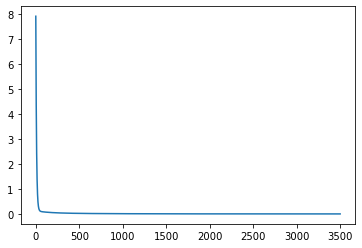

In [28]:
names = ['const'] + list(data.columns)
model_parameters(betas_no_reg[0], x_train, y_train, names)
plt.plot(betas_no_reg[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_no_reg[1][-1]))

In [29]:
betas_l1 = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [],threshold = 0, reg = 'l1', lambdaa = 0.1)

In [30]:
names = ['const'] + list(data.columns)
model_parameters(betas_l1[0], x_train, y_train, names)
# plt.plot(betas_l1[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_l1[1][-1]))

Model Output:

   Variable     Coeff       Std Err        T- Val
0     const  0.182860  9.247641e+06  1.977375e-08
1       MWG  0.270184  8.840207e-04  3.056310e+02
2       NWG  0.198043  8.832961e-04  2.242088e+02
3       KWG  0.039167  6.824034e-04  5.739595e+01
4     MDIMC -0.226405  1.018653e-03 -2.222596e+02
5     NDIMC -0.212586  1.020894e-03 -2.082348e+02
6     MDIMA  0.006400  8.557265e-04  7.478601e+00
7     NDIMB  0.016397  8.563045e-04  1.914840e+01
8       KWI  0.000765  6.701688e-04  1.141174e+00
9       VWM  0.016927  1.201074e-03  1.409301e+01
10      VWN  0.029673  1.203464e-03  2.465621e+01
11     STRM -0.018537  6.701678e-04 -2.766047e+01
12     STRN  0.003370  6.701697e-04  5.029077e+00
13       SA -0.029451  6.701681e-04 -4.394549e+01
14       SB -0.002420  6.701679e-04 -3.610359e+00


R2 of the estimated model: 0.5501951481802103
Adjusted R2 of the estimated model: 0.550155249225855
Mean Absolute Error: 0.11100065264633283
Mean Squared Error: 0.018987205367502893
M

c:\users\abhis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


In [31]:
betas_l2 = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [],threshold = 0, reg = 'l2', lambdaa = 0.1)

Model Output:

   Variable     Coeff       Std Err        T- Val
0     const  0.115387  9.732628e+06  1.185571e-08
1       MWG  0.271419  9.303827e-04  2.917281e+02
2       NWG  0.175456  9.296201e-04  1.887394e+02
3       KWG  0.041110  7.181916e-04  5.724033e+01
4     MDIMC -0.190496  1.072076e-03 -1.776891e+02
5     NDIMC -0.166998  1.074434e-03 -1.554289e+02
6     MDIMA  0.010537  9.006046e-04  1.170028e+01
7     NDIMB  0.036852  9.012128e-04  4.089156e+01
8       KWI  0.009291  7.053154e-04  1.317296e+01
9       VWM  0.051337  1.264063e-03  4.061232e+01
10      VWN  0.112331  1.266579e-03  8.868830e+01
11     STRM -0.010073  7.053144e-04 -1.428114e+01
12     STRN  0.011988  7.053163e-04  1.699722e+01
13       SA -0.020988  7.053147e-04 -2.975687e+01
14       SB  0.005976  7.053144e-04  8.472974e+00


R2 of the estimated model: 0.5017784845315053
Adjusted R2 of the estimated model: 0.5017342908830285
Mean Absolute Error: 0.11739756232753827
Mean Squared Error: 0.021030974197892436


c:\users\abhis\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


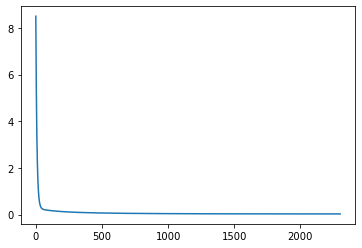

In [32]:
names = ['const'] + list(data.columns)
model_parameters(betas_l2[0], x_train, y_train, names)
plt.plot(betas_l2[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_l2[1][-1]))

### Model comparision

In [33]:
length = len(y_hat_ols)

y_hat_ols = model.predict(x_test)
err_ols = y_test.squeeze()-y_hat_ols

mae_ols = np.sum(np.absolute(err_ols))/length
mse_ols = np.sum(err_ols**2)/length
mape_ols = 100 * np.sum(np.absolute(1-err_ols/y_test.squeeze()))/length
rmse_ols = np.sqrt(np.sum(err_ols**2)/length)

In [34]:
y_hat_func_1 = x_test@betas_no_reg[0]
err_func_1 = y_test-y_hat_func_1

mae_func_1 = np.sum(np.absolute(err_func_1))/length
mse_func_1 = np.sum(err_func_1**2)/length
mape_func_1 = 100 * np.sum(np.absolute(1-err_func_1/y_test))/length
rmse_func_1 = np.sqrt(np.sum(err_func_1**2)/length)

In [35]:
y_hat_func_2 = x_test@betas_l1[0]
err_func_2 = y_test-y_hat_func_2

mae_func_2 = np.sum(np.absolute(err_func_2))/length
mse_func_2 = np.sum(err_func_2**2)/length
mape_func_2 = 100 * np.sum(np.absolute(1-err_func_2/y_test))/length
rmse_func_2 = np.sqrt(np.sum(err_func_2**2)/length)

In [36]:
y_hat_func_3 = x_test@betas_l2[0]
err_func_3 = y_test-y_hat_func_3

mae_func_3 = np.sum(np.absolute(err_func_3))/length
mse_func_3 = np.sum(err_func_3**2)/length
mape_func_3 = 100 * np.sum(np.absolute(1-err_func_3/y_test))/length
rmse_func_3 = np.sqrt(np.sum(err_func_3**2)/length)

In [37]:
comparision = pd.DataFrame({'OLS' : [mae_ols, mse_ols, mape_ols, rmse_ols],
               'No Regularization': [mae_func_1, mse_func_1, mape_func_1, rmse_func_1], 
               'L1': [mae_func_2, mse_func_2, mape_func_2, rmse_func_2], 
               'L2': [mae_func_3, mse_func_3, mape_func_3, rmse_func_3]}, ['MAE', 'MSE', 'MAPE', 'RSME'])
comparision

,OLS,No Regularization,L1,L2
MAE,0.108605,0.110473,0.110473,0.117017
MSE,0.018392,0.018816,0.018816,0.020882
MAPE,122.203420,122.351377,122.351377,122.731309
RSME,0.135617,0.137170,0.137170,0.144507
